## LangGraphs
- Langchain is an extension of LangChain that supports graphs.
- Single and multi-agent flows are described and represented as graphs
- Allows for extremely controlled "flows"
- The flow of graph is like cyclic graph in which a action is performed by agent given the response(observation) of LLM until the task is executed.
- The response of LLM is persistent. i.e, if the LLM fail to execute task it retries with new solution
- Built in persistence allows for human-in-the-loop workfkows

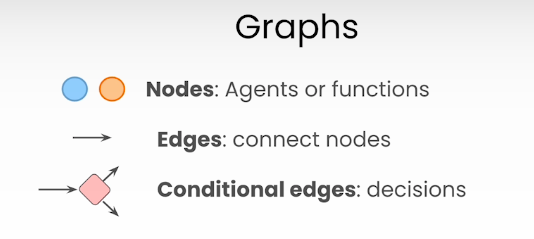

> **Disclaimer**: Currently, the Local LLM (i.e., Ollama served LLM) does not support agent functionality integration in either `ChatOllama` or `OllamaFunctions`. Attempting to use the model class with `OllamaFunctions` and an agent results in a JSON serialization error.
>
> Date: 2nd July 2024.

In [1]:
 # !pip install pygraphviz -q

In [2]:
import os
import operator
from typing import TypedDict, Annotated
from langchain_core.messages import (
    AnyMessage, 
    SystemMessage, 
    HumanMessage, 
    ToolMessage
    )
from langgraph.graph import StateGraph, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

from IPython.display import display, Markdown, Image

In [3]:
from dotenv import load_dotenv
# load .env file
load_dotenv()

True

In [4]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


#### Define the Agent State
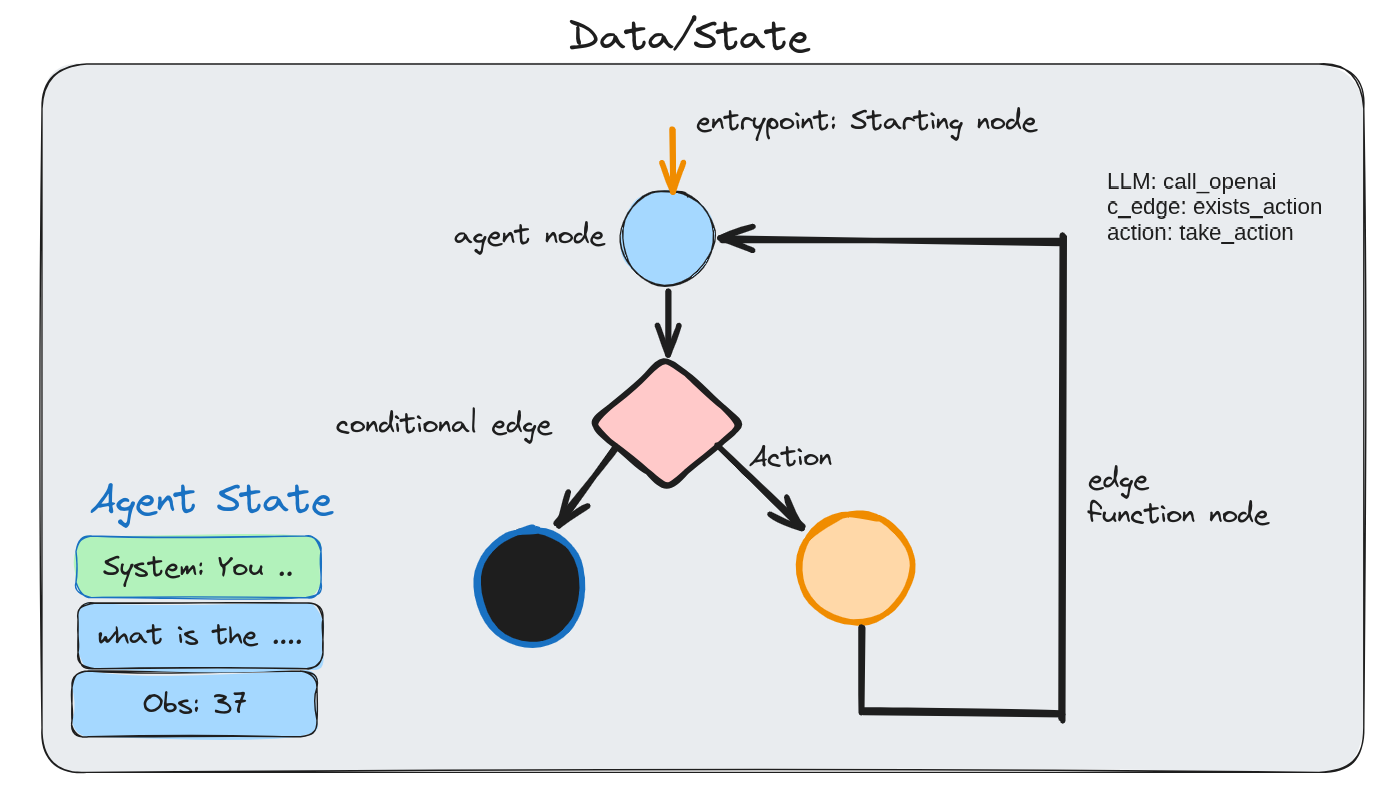
- Agent State is accessible to all parts of the graph
- It is local to the graph
- Can be stored in a persistence layer

**Simple State**
```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
```
**Complex state**
```python
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
```

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        # compile creates the langchain runnable after it is compiledd
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \ 
You are allowed to make multiple calls(either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up information before asking a follow up question, you are allowed to do that! 
"""

model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt)

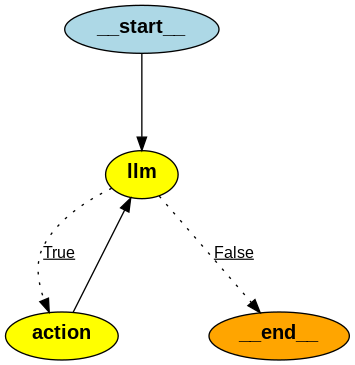

In [8]:
Image(abot.graph.get_graph().draw_png())

In [9]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Hrtb0JAU7iZzM7vmrsePJRdU', 'type': 'tool_call'}
Back to the model!


In [10]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hrtb0JAU7iZzM7vmrsePJRdU', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 155, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2acf9854-4769-495e-9e38-88f142c87264-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Hrtb0JAU7iZzM7vmrsePJRdU', 'type': 'tool_call'}], usage_metadata=

In [11]:
Markdown(result["messages"][-1].content)

The current weather in San Francisco is partly cloudy with a temperature of 46.9°F (8.3°C). The wind speed is 4.3 mph (6.8 kph) coming from the west-northwest direction. The humidity is at 80%, and the visibility is 9.0 miles.

In [12]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_6Cq4nwihUlvE8F6Hs4mb4eQ8', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_HchjrgsYeMMlDs7QTF73SfeD', 'type': 'tool_call'}
Back to the model!


In [13]:
Markdown(result['messages'][-1].content)

The current weather in San Francisco is partly cloudy with a temperature of 46.9°F. The wind speed is 6.8 km/h coming from the west-northwest. The humidity is at 80%. 

In Los Angeles, the current weather is misty with a temperature of 54.0°F. The wind speed is 3.6 km/h coming from the north-northwest. The humidity is at 90%.

In [14]:
# More advanced query
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_Dxe3IlXIQizoj76f4NJAashE', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_q4VPRyE32YdmYWR5L2aOUpYU', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2023'}, 'id': 'call_ZT5OvJDp0dgxMpUm4ty0zIXe', 'type': 'tool_call'}
Back to the model!


In [15]:
Markdown(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. In 2023, the GDP of Missouri was approximately $430 billion.